In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch.distributions import Multinomial
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from torch import nn
import matplotlib.pyplot as plt

In [2]:
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

---
* Funções de auxílio

In [3]:
def plots_dataset(X_tc):
    plt.figure(figsize=(20,7))
    plt.subplot(131)
    plt.plot(X_tc.data.numpy()[:,0],X_tc.data.numpy()[:,1],'bo')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.subplot(132)
    plt.plot(X_tc.data.numpy()[:,0],X_tc.data.numpy()[:,2],'bo')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 3")
    plt.subplot(133)
    plt.plot(X_tc.data.numpy()[:,1],X_tc.data.numpy()[:,2],'bo')
    plt.xlabel("Feature 2")
    plt.ylabel("Feature 3")
#     plt.savefig('images/gan-4',quality=100)
    plt.show()

def plots_dims(X_tc,G_sample_plot):
    plt.figure(figsize=(20,7))
    plt.subplot(131)
    plt.plot(X_tc.data.numpy()[:,0],X_tc.data.numpy()[:,1],'bo',label='Real')
    plt.plot(G_sample_plot.data.numpy()[:,0],G_sample_plot.data.numpy()[:,1],'rx',label='Falso')
    plt.legend(loc=0)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.subplot(132)
    plt.plot(X_tc.data.numpy()[:,0],X_tc.data.numpy()[:,2],'bo',label='Real')
    plt.plot(G_sample_plot.data.numpy()[:,0],G_sample_plot.data.numpy()[:,2],'rx',label='Falso')
    plt.legend(loc=0)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 3")
    plt.subplot(133)
    plt.plot(X_tc.data.numpy()[:,1],X_tc.data.numpy()[:,2],'bo',label='Real')
    plt.plot(G_sample_plot.data.numpy()[:,1],G_sample_plot.data.numpy()[:,2],'rx',label='Falso')
    plt.legend(loc=0)
    plt.xlabel("Feature 2")
    plt.ylabel("Feature 3")
#     plt.savefig('images/real_e_falso',quality=100)
    plt.show()

def plot_losses(losses_his):
    plt.figure(figsize=(20,8))
    plt.subplot(321)
    plt.plot(losses_his[0])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Gerador')
    plt.subplot(322)
    plt.plot(losses_his[1])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador')
    plt.subplot(323)
    plt.plot(losses_his[2])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador - Real')
    plt.subplot(324)
    plt.plot(losses_his[3])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador - Falso')
    plt.subplot(325)
    plt.plot(losses_his[4])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Q')
#     plt.savefig('images/losses_plot',quality=100)
    plt.show()
    
def choose_c(label,batch):
    chosen_label = label
    batch = batch
    a = np.zeros(shape=[batch, 10])
    a[:,chosen_label] = 1
    return torch.Tensor(a).type(torch.FloatTensor)

def get_X_from_c(label,batch):
    z = noise(batch, nz).to(device)
    c = choose_c(label,batch).to(device)
    return G(z,c).cpu()

def get_Xs_from_cs(batch):
    Xs = []
    for label in range(10):
        Xs.append(get_X_from_c(label,batch))
    return Xs

def choose_c_cont(label,batch):
    return torch.full((batch,1), label, device=device)

def get_X_from_c_cont(label,batch):
    z = noises(batch,nz,nu)[0]
    c = choose_c_cont(label,batch).to(device)
    return G(z,c).cpu()

def get_Xs_from_cs_cont(batch,lim_low,lim_hig):
    Xs = []
    label_vector = np.linspace(lim_low,lim_hig,10)
    for label in label_vector:
        Xs.append(get_X_from_c_cont(label,batch))
    return Xs

def plots_dims_with_cs(X_tc,plot_X=False, lim_low=False, lim_hig=False):
    if lim_low and lim_hig:
        X_fakes = get_Xs_from_cs_cont(X_tc.shape[0],lim_low,lim_hig)
    else: 
        X_fakes = get_Xs_from_cs(X_tc.shape[0])
    plt.figure(figsize=(20,7))
    plt.subplot(131)
    if plot_X:
        plt.plot(X_tc.data.numpy()[:,0],X_tc.data.numpy()[:,1],'bo',label='Real')
    for item, G_sample in enumerate(X_fakes):
        plt.plot(G_sample.data.numpy()[:,0],G_sample.data.numpy()[:,1],'x',label=f'{item}')
    plt.legend(loc=0)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.subplot(132)
    if plot_X:
        plt.plot(X_tc.data.numpy()[:,0],X_tc.data.numpy()[:,2],'bo',label='Real')
    for item, G_sample in enumerate(X_fakes):
        plt.plot(G_sample.data.numpy()[:,0],G_sample.data.numpy()[:,2],'x',label=f'{item}')
    plt.legend(loc=0)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 3")
    plt.subplot(133)
    if plot_X:
        plt.plot(X_tc.data.numpy()[:,1],X_tc.data.numpy()[:,2],'bo',label='Real')
    for item, G_sample in enumerate(X_fakes):
        plt.plot(G_sample.data.numpy()[:,1],G_sample.data.numpy()[:,2],'x',label=f'{item}')
    plt.legend(loc=0)
    plt.xlabel("Feature 2")
    plt.ylabel("Feature 3")
    plt.show()

    
def nets_test(n_sample,G,D,nz,nu):
    z = noise(n_sample,nz).to(device)
    c = noise_uniform(n_sample).to(device)
    x = torch.Tensor(X_tc[:n_sample]).to(device)
    g = G(z,c)
    D_real = D(x)[0]
    D_fake = D(g)[0]
    print('Average D_real  {:.4f}| Std D_real  {:.4f}'.format(D_real.mean(),D_real.std()))
    print('Average D_fake  {:.4f}| Std D_fake  {:.4f}'.format(D_fake.mean(),D_fake.std()))
    
def check_c_accuracy(n_sample,Q,G,D,nz,nu):
    z = noise(n_sample, nz).to(device)
    c = noise_uniform(n_sample).to(device)
    c_expected = Q(D(G(z,c))[1])
    acc = (torch.max(c_expected,dim=1)[1] == torch.max(c,dim=1)[1]).sum().item()/n_sample
    print('Q accuracy  {:.2f}%'.format(acc*100))
    
def noise__(dim0,dim1):
    return Variable(Normal(loc=0, scale=5).sample(sample_shape=torch.Size([dim0,dim1])))

def noise(dim0,dim1):
    return torch.randn(dim0, dim1, device=device)

def noise_discrete(dim0,dim1):
    c = Multinomial(probs=torch.Tensor([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]))\
    .sample(sample_shape=torch.Size([dim0,1,1]))\
    .reshape(dim0,dim1,1,1).to(device)
    return c

def noise_uniform(dim0):
    c = Uniform(torch.tensor([-1.0]), torch.tensor([1.0]))\
    .sample(sample_shape=torch.Size([dim0])).to(device)
    return c

def noises(X_size,nz,nu):
    z = noise(X_size,nz)
    c = noise_uniform(X_size)
    return z,c

def gaussian_sample(mu_expected,var_expected, dim):
    return Normal(mu_expected.reshape(dim,1),var_expected.reshape(dim,1)).sample()

---

In [4]:
def gen_data(a,b,size):
    noise_ = np.random.normal(size=size)
    x1 = 2*np.pi*np.linspace(a,b,size)
    x2 = x1*np.cos(2*x1)+noise_*0.25
    x3 = np.exp(-x1)*x1+noise_*0.010

    X_data = np.concatenate((x1.reshape(x1.shape[0],1),\
                           x2.reshape(x1.shape[0],1),\
                           x3.reshape(x1.shape[0],1)),axis=1)
    return X_data

data = gen_data(0,1,5000)

In [5]:
scaler = StandardScaler()
data = scaler.fit_transform(data)
data_tc = torch.Tensor(data).type(torch.FloatTensor)
X_tc = data_tc[:4000]
print(X_tc.shape, X_tc.type())

torch.Size([4000, 3]) torch.FloatTensor


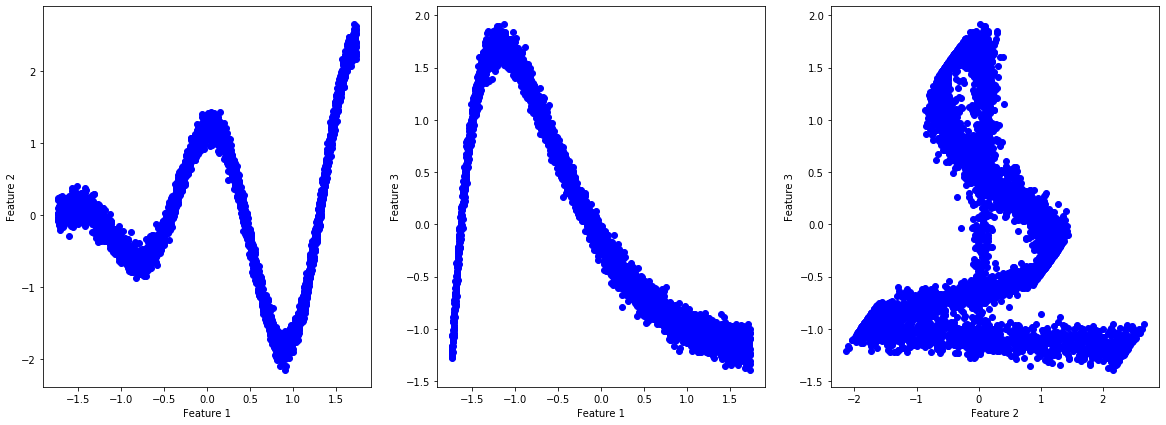

In [6]:
plots_dataset(data_tc)

In [7]:
nz,nu,h_dim,X_dim = [50,1,200,X_tc.shape[1]]

# Arquitetura do Gerador
class GNet(torch.nn.Module):
    def __init__(self):
        super(GNet,self).__init__()
        self.hidden1 = torch.nn.Linear(nz + nu, h_dim)
        self.hidden2 = torch.nn.Linear(h_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, X_dim)
    
    def forward(self,z,c):
        h = F.relu(self.hidden1(torch.cat((z,c),dim=1)))
        h = F.relu(self.hidden2(h))
        X = self.out(h)
        return X

# Arquitetura do Discriminador
class DNet(torch.nn.Module):
    def __init__(self):
        super(DNet,self).__init__()
        self.hidden = torch.nn.Linear(X_dim, h_dim)
        self.hidden2 = torch.nn.Linear(h_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, 1)
    
    def forward(self,X):
        h = F.relu(self.hidden(X))
        h2 = F.relu(self.hidden2(h))
        y = torch.sigmoid(self.out(h2))
        head = self.hidden2(h)
        return y, head

class QNet(torch.nn.Module):
    def __init__(self):
        super(QNet,self).__init__()
        self.hidden = torch.nn.Linear(h_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, 1)
        self.out2 = torch.nn.Linear(h_dim, 1)
    
    def forward(self,head):
        h1 = F.relu(self.hidden(head))
        mu = self.out(h1)
        var = torch.exp(self.out2(h1))
        return mu, var

# Instanciamos as redes
G = GNet().to(device)
D = DNet().to(device)
Q = QNet().to(device)
# Definimos os otimizadores
lrg,lrd,lrq = [1e-3,1e-3,1e-3]
beta = 0.9
G_optim = optim.Adam(G.parameters(), lr=lrg, betas=(beta,0.999))
D_optim = optim.Adam(D.parameters(), lr=lrd, betas=(beta,0.999))
Q_optim = optim.Adam(Q.parameters(), lr=lrq, betas=(beta,0.999))

def reset_grad():
    G_optim.zero_grad()
    D_optim.zero_grad()
    Q_optim.zero_grad()

def Q_loss_func(c_expected, c):
    return torch.mean(-torch.sum(c * torch.log(c_expected + 1e-8), dim=1)) + 3

def entropy(x):
    return -1*(torch.softmax(x, dim=1) * torch.log_softmax(x, dim=1)).sum()

# funções de perda
mse = nn.MSELoss()
loss = nn.BCELoss()

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight).to(device)
        m.bias.data.fill_(0.001)  
    
#Inicializar pesos das redes
G.apply(init_weights)
D.apply(init_weights)
Q.apply(init_weights)

batch = X_tc.shape[0]
real_label = 1
fake_label = 0

G_his, D_his, D_real_his, D_fake_his, Q_his = [[],[],[],[],[]]
losses_his = [G_his,D_his,D_real_his,D_fake_his,Q_his] 

In [8]:
#load models
G.load_state_dict(torch.load('models/g_infodcgan_example_cont.pt'))
D.load_state_dict(torch.load('models/d_infodcgan_example_cont.pt'))
Q.load_state_dict(torch.load('models/q_infodcgan_example_cont.pt'))

<All keys matched successfully>

In [16]:
%%time
epochs = 5000

for epoch in range(epochs):
    # Amostragem de dados
    X = X_tc.to(device)
    X_size = X.shape[0]
    z,c = noises(X_size,nz,nu)
    ones = torch.full((X_size,), real_label, device=device)
    zeros = torch.full((X_size,), fake_label, device=device)
    
    # Dicriminador
    G_sample = G(z,c)
    D_real = D(X)[0]
    D_fake, X_hidden = D(G_sample)
    D_loss_real = loss(D_real, ones.view(-1))
    D_loss_fake = loss(D_fake, zeros.view(-1))
    D_loss = D_loss_real + D_loss_fake
    D_loss.backward(retain_graph=True)
    D_optim.step()

    # Q network
    mu_expected, var_expected = Q(X_hidden)
    Q_loss = mse(c,mu_expected)
    Q_loss = Variable(Q_loss, requires_grad=True)
    Q_loss.backward()
    Q_optim.step()
    reset_grad()

    # Generador
    z,c = noises(X_size,nz,nu)
    G_sample = G(z,c)
    D_fake, X_hidden = D(G_sample)
    mu_expected, var_expected = Q(X_hidden)
    Q_loss = mse(c,mu_expected)
    Q_loss = Variable(Q_loss, requires_grad=True)
    G_loss = loss(D_fake, ones.view(-1)) + Q_loss
    G_loss.backward()
    G_optim.step()
    reset_grad()

    # Recolher dados das funções de perda
    G_his.append(G_loss.data)
    D_his.append(D_loss.data)
    D_fake_his.append(D_loss_fake.data)
    D_real_his.append(D_loss_real.data)
    Q_his.append(Q_loss.data)
    # Mostrar dados ao longo das epochs
    if epoch % int(epochs/5) == 0 and epoch > 0:
        print("""Epoch-{}| Average D_loss: {:.3f}| Average G_loss: {:.3f}|
        Average D_real: {:.3f} | Average D_fake: {:.3f} | Average Q_loss: {:.3f}""".format(
            epoch, D_loss.data, G_loss.data, D_loss_real.data, D_loss_fake.data, Q_loss.data))
        nets_test(10000,G,D,nz,nu)
        print('-'*100)

Epoch-1000| Average D_loss: 1.401| Average G_loss: 1.276|
        Average D_real: 0.694 | Average D_fake: 0.707 | Average Q_loss: 0.570
Average D_real  0.5153| Std D_real  0.1243
Average D_fake  0.5012| Std D_fake  0.0795
----------------------------------------------------------------------------------------------------
Epoch-2000| Average D_loss: 1.432| Average G_loss: 1.249|
        Average D_real: 0.706 | Average D_fake: 0.727 | Average Q_loss: 0.503
Average D_real  0.5084| Std D_real  0.1480
Average D_fake  0.4913| Std D_fake  0.1206
----------------------------------------------------------------------------------------------------
Epoch-3000| Average D_loss: 1.298| Average G_loss: 1.118|
        Average D_real: 0.652 | Average D_fake: 0.646 | Average Q_loss: 0.360
Average D_real  0.5335| Std D_real  0.1193
Average D_fake  0.4731| Std D_fake  0.0256
----------------------------------------------------------------------------------------------------
Epoch-4000| Average D_loss: 1.3

In [17]:
nets_test(10000,G,D,nz,nu)

Average D_real  0.4737| Std D_real  0.0310
Average D_fake  0.4661| Std D_fake  0.0357


In [23]:
#save
# torch.save(G.state_dict(), 'models/g_infodcgan_example_cont.pt')
# torch.save(D.state_dict(), 'models/d_infodcgan_example_cont.pt')
# torch.save(Q.state_dict(), 'models/q_infodcgan_example_cont.pt')

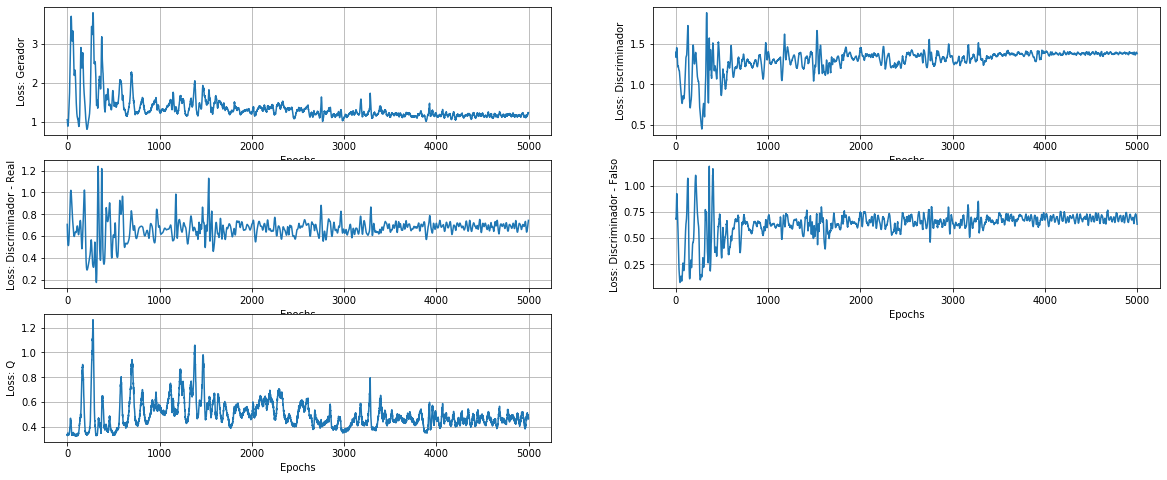

In [18]:
plot_losses(losses_his)

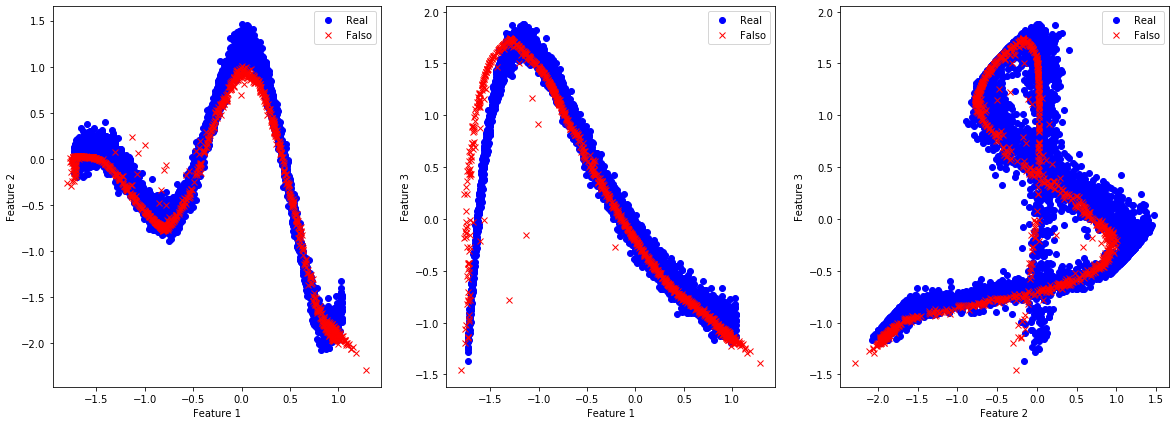

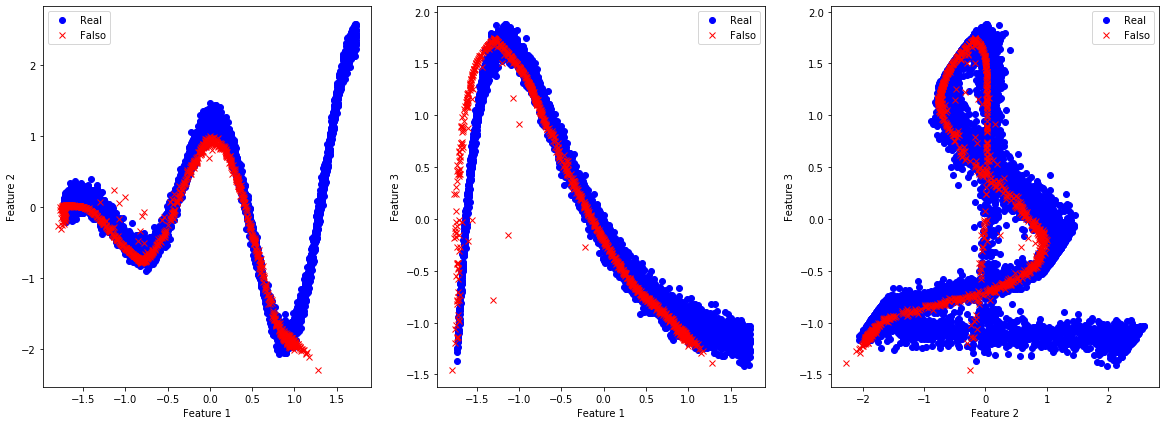

In [19]:
batch_test = 1000
z = noise(batch_test, nz).to(device)
c = noise_uniform(batch_test).to(device)
G_sample_plot = G(z,c).cpu()
plots_dims(X_tc,G_sample_plot)
plots_dims(data_tc,G_sample_plot)

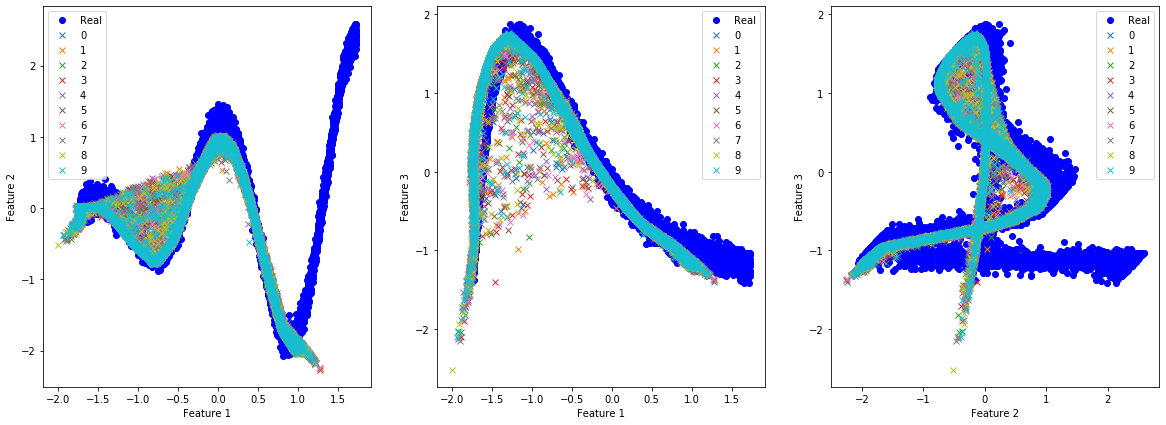

In [25]:
plots_dims_with_cs(data_tc,plot_X=True, lim_low=-1, lim_hig=1)

Valor: -25


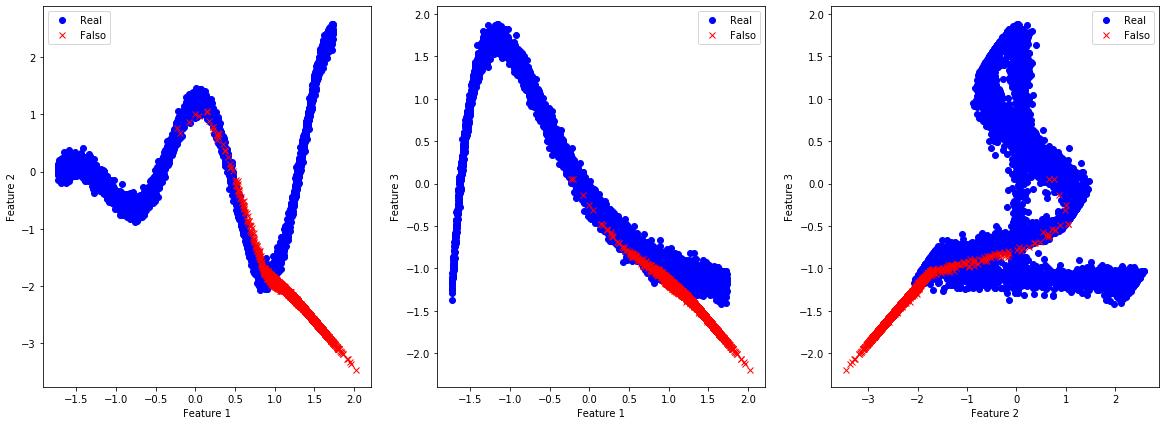

Valor: -20


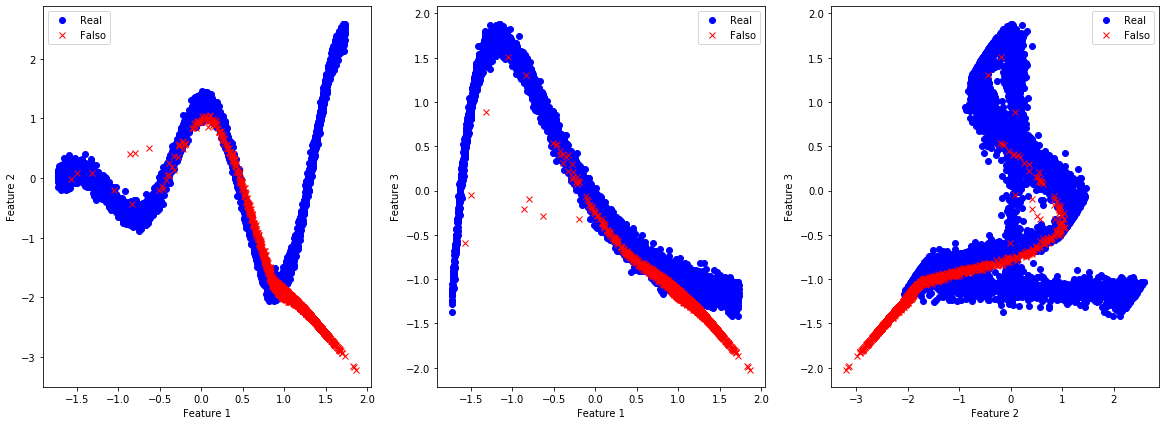

Valor: -15


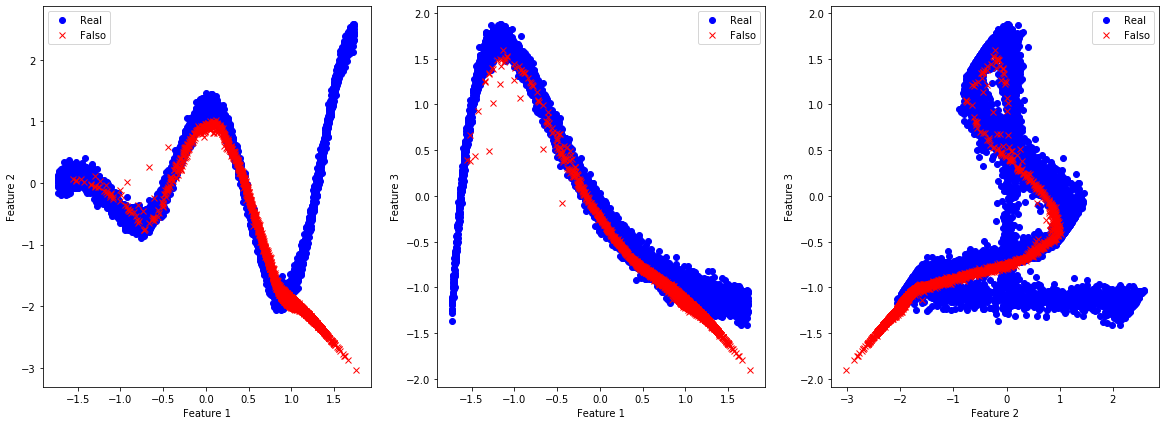

Valor: 15


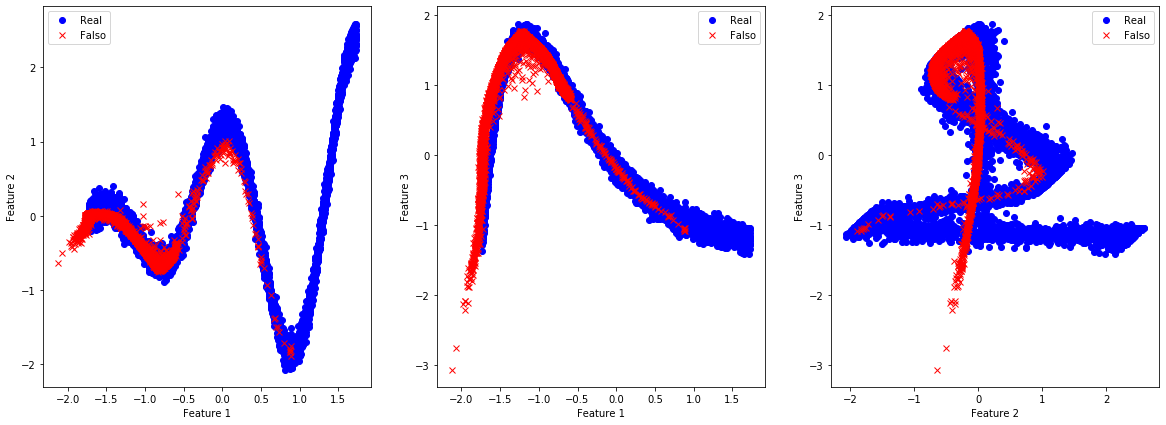

Valor: 20


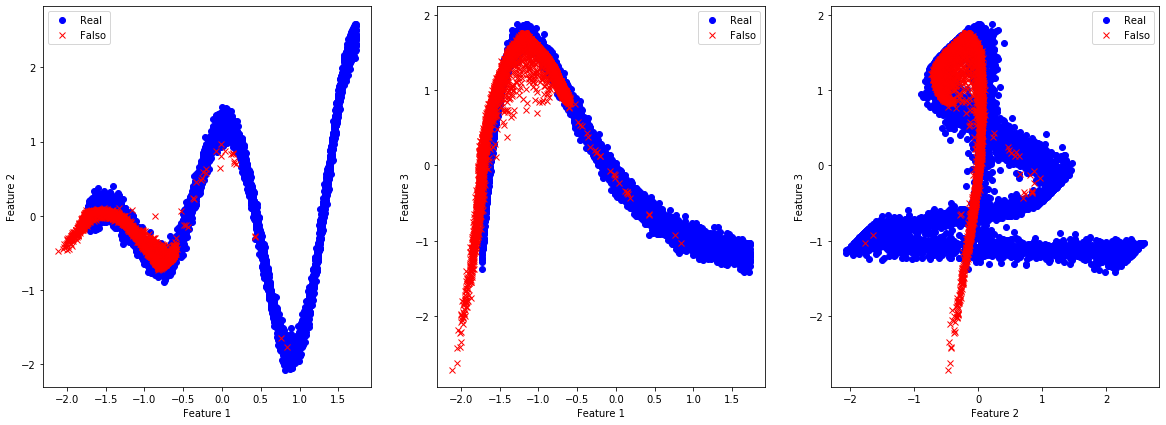

Valor: 25


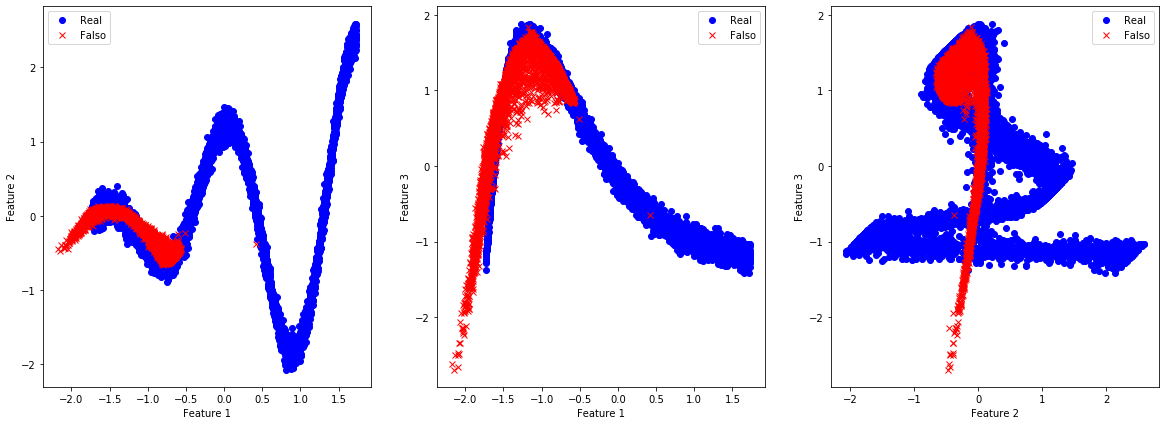

In [21]:
for i in [-25,-20,-15,15,20,25]:
    print("Valor:",i)
    plots_dims(data_tc,get_X_from_c_cont(label=i,batch=5000))

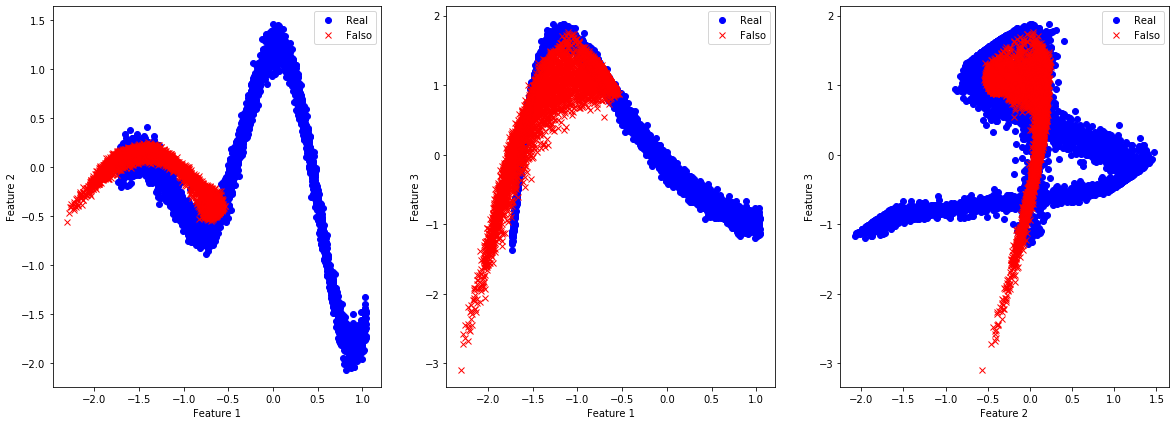

In [22]:
plots_dims(X_tc,get_X_from_c_cont(label=35,batch=5000))

* Avaliando o resultado

In [29]:
z,c = noises(4000,nz,nu)
X_fake = G(z,c)

In [30]:
# DataFrame real
df_real = pd.DataFrame(data=X_tc.data.numpy(),columns=['x1','x2','x3'])
df_real['reality_label'] = 1
# DataFrame falso
df_fake = pd.DataFrame(data=X_fake.cpu().data.numpy(),columns=['x1','x2','x3'])
df_fake['reality_label'] = 0
# Concatemos e embaralhamos os dois
df_mixed = pd.concat([df_real,df_fake],axis=0)
df_mixed = df_mixed.sample(frac=1.0)
# Separamos o label para ser o target
X_mixed = df_mixed.drop('reality_label',axis=1).copy()
y_mixed = df_mixed['reality_label'].copy()
# Transformamos em tensores
X_mix_tc = torch.Tensor(X_mixed.values).type(torch.FloatTensor)
y_mix_tc = torch.Tensor(y_mixed.values).type(torch.FloatTensor).cpu()

In [31]:
# Previsão
y_predict,_ = D(X_mix_tc.to(device))

In [32]:
print("Confusion Matrix:")
print(confusion_matrix(y_mix_tc.data.numpy().reshape(y_mix_tc.shape[0],),np.round(y_predict.cpu().data.numpy().reshape(y_predict.shape[0],),0)))

Confusion Matrix:
[[2395 1605]
 [1924 2076]]


In [33]:
print("Classification Report:")
print(classification_report(y_mix_tc.data.numpy().reshape(y_mix_tc.shape[0],),
                            np.round(y_predict.cpu().data.numpy().reshape(y_predict.shape[0],),0),digits=5))

Classification Report:
              precision    recall  f1-score   support

         0.0    0.55453   0.59875   0.57579      4000
         1.0    0.56398   0.51900   0.54055      4000

    accuracy                        0.55888      8000
   macro avg    0.55925   0.55888   0.55817      8000
weighted avg    0.55925   0.55888   0.55817      8000



## Plot interativo

In [44]:
import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display
%matplotlib inline

In [27]:
def plots_dims(X_tc,G_sample_plot):
    plt.figure(figsize=(20,7))
    plt.subplot(131)
    plt.plot(X_tc.data.numpy()[:,0],X_tc.data.numpy()[:,1],'bo',label='Real')
    plt.plot(G_sample_plot.data.numpy()[:,0],G_sample_plot.data.numpy()[:,1],'rx',label='Falso')
    plt.legend(loc=0)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.xlim(-2.5,2.5)
    plt.ylim(-2.5,2.5)
    plt.grid(True)
    plt.subplot(132)
    plt.plot(X_tc.data.numpy()[:,0],X_tc.data.numpy()[:,2],'bo',label='Real')
    plt.plot(G_sample_plot.data.numpy()[:,0],G_sample_plot.data.numpy()[:,2],'rx',label='Falso')
    plt.legend(loc=0)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 3")
    plt.xlim(-2.5,2.5)
    plt.ylim(-2.5,2.5)
    plt.grid(True)
    plt.subplot(133)
    plt.plot(X_tc.data.numpy()[:,1],X_tc.data.numpy()[:,2],'bo',label='Real')
    plt.plot(G_sample_plot.data.numpy()[:,1],G_sample_plot.data.numpy()[:,2],'rx',label='Falso')
    plt.legend(loc=0)
    plt.xlabel("Feature 2")
    plt.ylabel("Feature 3")
    plt.xlim(-2.5,2.5)
    plt.ylim(-2.5,2.5)
    plt.grid(True)
#     plt.savefig('images/real_e_falso',quality=100)
    plt.show()

In [19]:
def interactive_plot(i):
    plots_dims(data_tc,get_X_from_c_cont(label=i,batch=5000))

In [23]:
interactive_plot_ = interactive(interactive_plot, i=(-50,50,1))
output2 = interactive_plot_.children[0]
output2.layout.width = "500px"
output = interactive_plot_.children[-1]
output.layout.height = '450px'

In [28]:
interactive_plot_

interactive(children=(IntSlider(value=29, description='i', layout=Layout(width='500px'), max=50, min=-50), Out…

In [48]:
def filter_by_x1(x1):
    df = df_mixed[df_mixed['x1']>=x1].copy()
    display(df.shape)
    display(df.sort_values(by='x2').iloc[:10])

In [54]:
def plots_dims2(x1):
    df = df_mixed[df_mixed['x1']>=x1].copy()
    plt.figure(figsize=(8,3))
    plt.plot(df.values[:,0],df.values[:,1],'rx')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.xlim(-2.5,2.5)
    plt.ylim(-2.5,2.5)
    plt.grid(True)
    plt.show()

In [56]:
a = widgets.FloatSlider(description="Delayed", min=df_mixed['x1'].min(), max=df_mixed['x1'].max(), continuous_update=True)
ui = widgets.HBox([a])
out = widgets.interactive_output(filter_by_x1, {'x1': a})
out2 = widgets.interactive_output(plots_dims2, {'x1': a})

display(ui, out,out2)

Output()

Output()